# Leaky Integrate-and-fire model

## Introduction

Leaky Integrate-and-fire model(LIF model) is a single neuron model, which simplifies the neural activity to a combination of two mechanisms: "integrate" and "fire". 

Adv: Simple enough. LIF model can catch the primary properties with low computation cost, makes it possible to simulate large scale network with thousands of neurons at the same time.

Con: Too simple. LIF model ignores most of the minor properties, which can be important for specific research topic.

To convert a biological neuron to a computational model, we can simplify it as a RC circuit with a battery. 

When an external input current $I(t)$ is given to a neuron, it will go through the membrane. The cell membrane is a good insulator, so when the charge $Q = \int_{-\infty}^{+\infty} {I(t)}\,{\rm d}t$ arrives, the membrane will act as a capacitor $C$; on the other hand, charge also can leak across the membrane, so it act as a resistor $R$ in the meantime. The resting potential $u_{rest}$ is added to the circuit as a battery.

<img src="../_static/LIF-1.png">

In the picture above, the battery refers to $u_{rest}$, $R$ refers to membrane resistance, and these two components are parallel with $C$, which refers to membrane capacitance. $I(t)$ is external input injected by an experimentalist or transmitted by synapses. $u(t)$ refers to membrane potential.

## Method

In [1]:
import numpy as np
import npbrain as nb
import matplotlib.pyplot as plt

In [2]:
## set global params
# set rand seed
np.random.seed(42) 
# set params
dt = 0.02        # update variables per <dt> ms
duration = 100.  # simulate duration
nb.profile.set(backend = "numpy", dt = dt, merge_ing = True)

### "Integrate" Component

Suppose $I_R$ is the current passes through $R$, $I_C$ is the current passes through $C$, According to Kirchhoff's law, we can get the equation:

$$I(t) = I_R + I_C$$

In which 

$$I_R = \frac{U_R}{R} = \frac{u(t) - u_{rest}}{R}$$

and

$$I_C = \frac{dq}{dt}$$

because $q = Cu$,

$$I_C = \frac{dq}{dt} = \frac{dCu}{dt} = C\frac{du}{dt}$$

Therefore,

$$C\frac{du}{dt} = -\frac{u(t) - u_{rest}}{R} + I(t)$$

Suppose $\tau_m = RC$,

$$\tau_m \frac{du}{dt} = - (u(t) - u_{rest}) + RI(t)$$

This is an inhomogeneous first-order linear ordinary differential equation. We can get the solution of it by numerical methods. Fortunately, npbrain provides a decorator called @npbrain.integrate to help users transfer differential equation to code of numerical methods. Users provide the right hand of differential equation (i.e. $-(u(t)-u_{rest})+RI(t)$ in LIF model, or any expression in other models) and the decorator will transfer it to the code form in which numerical methods can be applied.

### "Fire" Component

The membrane potential $u(t)$ will integrate, and normally it will increase until meeting the firing threshold, i.e. $Vth$, which is about 20mV above resting potential.When $u(t)$ is increasing and meet $Vth$, $u(t)$ will first jump to a value high above $Vth$, then return to $u_{reset}$ (a value usually lower than $u_{rest}$, in this experiment we just set it equal to $u_{rest}$) soon.

During the progress of "jump" and "reset", we say the neuron fires and generates a spike. The progress is fast, so we can ignore the "jump" part, directly reset $u(t)$ to $u_{reset}$ while simulating LIF model. After reset, the neuron begin to integrate again.

In [3]:
## define Leaky Integrate-and-Fire model
def LIF_model(Vr = 0, Vth = 20, Rm = 1, Cm = 10, tau_m = 10, refTime = 5, noise = 0.):
    ST = nb.types.NeuState(
        {'Vm': 0, 'refState': -1e7, 'input':0, 'spikeCnt':0}, 
        help = '''
            LIF neuron model.
            Vm: voltage of membrane.
            refState: refractory state
            input: external input, from stimulus and other synapses
            spikeCnt: total spike cnt (record to compute firing rate)
        '''
    )
    
    @nb.integrate(noise = noise)
    def int_v(V, _t_, input):  # integrate u(t)
        return (- ( V - Vr ) + Rm * input) / tau_m

    def update(ST, _t_):  
        # update variables
        refPeriod = refTime // dt  #refractory
        if ST['refState'] <= 0:
            V = int_v(ST['Vm'], _t_, ST['input'])
            if V >= Vth:
                V = Vr
                ST['refState'] = refPeriod
                ST['spikeCnt'] += 1
            ST['Vm'] = V
        else:
            ST['refState'] -= 1
        ST['input'] = 0.  #ST['input'] is current input (only valid for current step, need reset each step)
    
    return nb.NeuType(name = 'LIF_neuron', requires = dict(ST=ST), steps = update, vector_based = False)

npbrain supports 1D/2D neuron networks. In this example, we create a neuron group including 10 neurons, then convert it into a network. Using function <code>npbrain.network.run()</code>, an input is added on the net, and we simulate the net for 100ms. Two randomly chosen neurons' u-t plots are drawn.

Compilation used 2.1958 ms.
Start running ...
Run 10.0% using 0.098 s.
Run 20.0% using 0.163 s.
Run 30.0% using 0.238 s.
Run 40.0% using 0.279 s.
Run 50.0% using 0.353 s.
Run 60.0% using 0.412 s.
Run 70.0% using 0.500 s.
Run 80.0% using 0.593 s.
Run 90.0% using 0.638 s.
Run 100.0% using 0.709 s.
Simulation is done in 0.711 s.


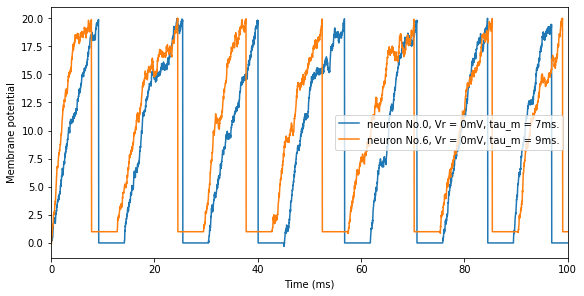

In [4]:
neu = nb.NeuGroup(LIF_model, geometry = (10, ), monitors = ['Vm'],
                  pars_update = {
                  'Vr': np.random.randint(0, 2, size = (10,)),
                  'tau_m': np.random.randint(5, 10, size = (10,)),
                  'noise': 1.
                 })  #create a neuron group with 10 neurons.
net = nb.Network(neu)
net.run(duration = duration, inputs = [neu, "ST.input", 26.], report = True)  
#simulate for 100 ms. Give external input = [receiver, field name, strength]
    
#paint
ts = net.ts
fig, gs = nb.visualize.get_figure(1, 1, 4, 8)

fig.add_subplot(gs[0, 0])
plt.plot(ts, neu.mon.Vm[:, 0], label = f'neuron No.{0}, Vr = {neu.pars_update["Vr"][0]}mV, tau_m = {neu.pars_update["tau_m"][0]}ms.')
plt.plot(ts, neu.mon.Vm[:, 1], label = f'neuron No.{6}, Vr = {neu.pars_update["Vr"][6]}mV, tau_m = {neu.pars_update["tau_m"][6]}ms.')
#paint Vm-t plot of 1st and 2nd neuron
plt.ylabel('Membrane potential')
plt.xlim(-0.1, net._run_time + 0.1)
plt.legend()
plt.xlabel('Time (ms)')

plt.show()

## Analysis

<img src="../_static/LIF-2.png">

This graph presents the u-t plot of a single neuron. With noisy input, this neuron fires with certain stochasticity, but the interval between spikes are still basically the same.

### spike pattern under constant input

Compilation used 0.0000 ms.
Start running ...
Run 10.0% using 0.131 s.
Run 20.0% using 0.269 s.
Run 30.0% using 0.400 s.
Run 40.0% using 0.565 s.
Run 50.0% using 0.718 s.
Run 60.0% using 0.876 s.
Run 70.0% using 1.039 s.
Run 80.0% using 1.187 s.
Run 90.0% using 1.335 s.
Run 100.0% using 1.500 s.
Simulation is done in 1.501 s.


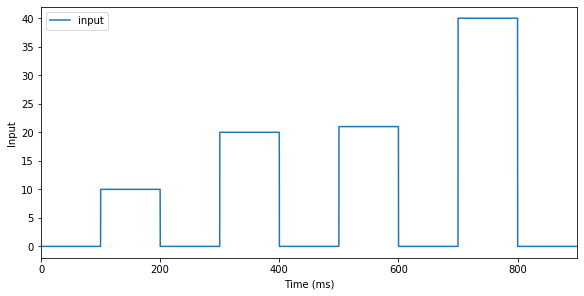

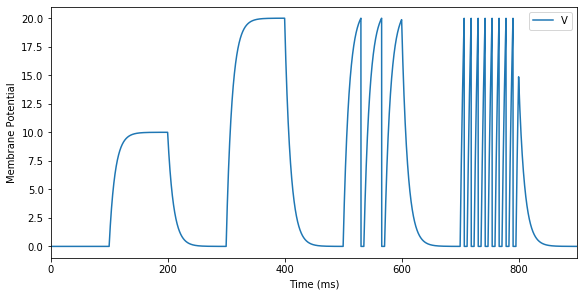

In [5]:
# spike pattern under constant input current of different amplitude
# make input
current, pos_dur = nb.inputs.constant_current([(0, duration), (10, duration), 
                                               (0, duration), (20, duration), 
                                               (0, duration), (21, duration),
                                               (0, duration), (40, duration),
                                               (0, duration)
                                              ])


single_neu1 = nb.NeuGroup(LIF_model, geometry = (1, ), monitors = ['Vm'],
                          pars_update = {
                          'Vr': 0,
                          'tau_m': 10,
                          'noise': 0
                         })  #create a single neuron.
net = nb.Network(single_neu1)

#simulate
net.run(duration = pos_dur, inputs = [single_neu1, "ST.input", current], report = True)

#paint
ts = net.ts
fig, gs = nb.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Input')
plt.xlim(-0.1, net._run_time + 0.1)
plt.plot(ts, current, label = f'input')
plt.legend()
plt.show()

fig, gs = nb.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential')
plt.xlim(-0.1, net._run_time + 0.1)
plt.plot(ts, single_neu1.mon.Vm[:, 0], label = f'V')
plt.legend()
plt.show()

A single neuron is simulated above. Four constant stimuli are added on the neuron successively, each lasts for $100ms$, and their amplitudes are $10$, $20$, $21$, $40$, respectively. Noise is excluded in this experiment to find an accurate critical constant stimulus $I(t) = I_0$, which can elicit a spike in the neuron.

As we can see, when $I(t) = 10$, the neuron does not fire; when $I(t) = 20$, the final value of $u(t)$ is close to threshold $Vth$, but still, it won't fire; when $I(t) = 21$, the neuron fire with a regular pattern; when $I(t) = 40$, the neuron fires regularly, and obviously it's firing rate is higher than the one when $I(t) = 21$.

The critical value of external constant input to elicit a spike is $20$. When the input constant current $I_0$ is higher than $20$, the neuron will fire regularly, otherwise it won't fire.

We have got the critical current value by simulation, now let's have a look at some math.

Suppose $u(0) = u_{rest}$, input $I(t)$ is constant current $I_0$, then the solution of differential equation is

$$u(t) = u_{rest} + RI_0(1-e^{-\frac{t}{\tau_m}})$$

When $t\to+\infty$, $u(t)\to u_{rest}+RI_0$. As we suppose $R = 1$, $Vth = 20$, so the critical value $I(t)$ should be the one make $u(t) \to Vth$, i.e. $20$.

Therefore, the simulation result accords with math deduction.

### Firing rate - input plot

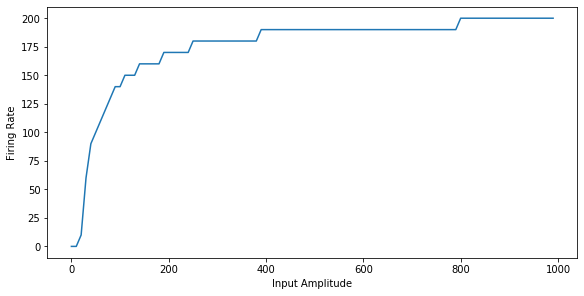

In [9]:
# Relation between firing rate and input amplitude
amplitudeList = []  # input amplitude list
fRateList = []      # firing rate list

for i in range(0, 1000, 10):
    current, pos_dur = nb.inputs.constant_current([(i, duration)])
    single_neu2 = nb.NeuGroup(LIF_model, geometry = (1, ), monitors = ['Vm', 'spikeCnt'],
                          pars_update = {
                          'Vr': 0,
                          'tau_m': 10,
                          'noise': 1
                         })  #create a single neuron.
    net = nb.Network(single_neu2)
    
    net.run(duration = pos_dur, inputs = [single_neu2, "ST.input", current], report = False)

    amplitudeList.append(i)
    fRateList.append(single_neu2.mon.spikeCnt[-1, 0] * (1000/duration))

fig, gs = nb.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.xlabel('Input Amplitude')
plt.ylabel('Firing Rate')
plt.plot(amplitudeList, fRateList)
plt.show()

Refractory is 5ms, so the maximum firing rate is limited to 200 ($= \frac{1s}{5ms}$), as presented below.

<img src="../_static/LIF-3.png">

If ignores refractory (set refractory period to 0), then the time $t$ LIF model needs to integrate from $u(0) = u_{rest}$ to $u(t) = Vth$ is proportional to $ln(\frac{I_0}{I_0-Vth})$(suppose constant input $I(t) = I_0$). When $I_0\to+\infty$, $ln(\frac{I_0}{I_0-Vth})\to0$. therefore the firing rate will increase to $+\infty$, as presented below.

<img src="../_static/LIF-4.png">

### Spiking pattern under diverse input

Compilation used 0.0000 ms.
Start running ...
Run 10.0% using 0.020 s.
Run 20.0% using 0.034 s.
Run 30.0% using 0.047 s.
Run 40.0% using 0.068 s.
Run 50.0% using 0.093 s.
Run 60.0% using 0.116 s.
Run 70.0% using 0.132 s.
Run 80.0% using 0.156 s.
Run 90.0% using 0.170 s.
Run 100.0% using 0.186 s.
Simulation is done in 0.186 s.
Compilation used 0.0000 ms.
Start running ...
Run 10.0% using 0.023 s.
Run 20.0% using 0.044 s.
Run 30.0% using 0.064 s.
Run 40.0% using 0.087 s.
Run 50.0% using 0.109 s.
Run 60.0% using 0.134 s.
Run 70.0% using 0.156 s.
Run 80.0% using 0.172 s.
Run 90.0% using 0.193 s.
Run 100.0% using 0.215 s.
Simulation is done in 0.215 s.


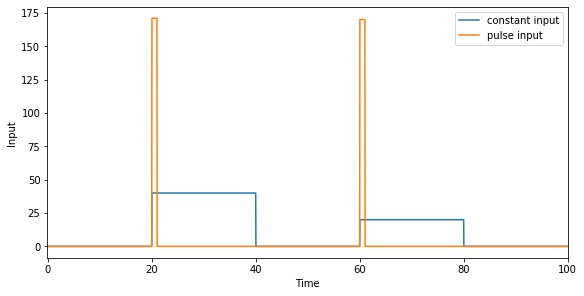

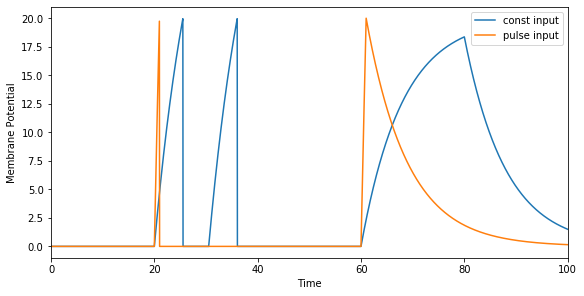

In [6]:
# Spiking pattern under constant input & pulse input
#set params
Vr = 0
tau_m = 8

# const input
current, pos_dur = nb.inputs.constant_current([(0, 20), (40, 20), (0, 20), (20, 20), (0, 20)])
single_neu3 = nb.NeuGroup(LIF_model, geometry = (1, ), monitors = ['Vm'],
                          pars_update = {
                          'Vr': Vr,
                          'tau_m': tau_m,
                          'noise': 0.
                         })  #create a single neuron.
net = nb.Network(single_neu3)
#simulate
net.run(duration = pos_dur, inputs = [single_neu3, "ST.input", current], report = True)

dur_cst = net.ts
input_cst = current
potential_cst = single_neu3.mon.Vm[:, 0]

#pulse input
current = nb.inputs.spike_current([20,  60],    # pulse points
                                  [1,   1],     # pulse durations
                                  [171, 170],   # pulse strength/sizes
                                  duration)     # total duration
single_neu4 = nb.NeuGroup(LIF_model, geometry = (1, ), monitors = ['Vm'],
                          pars_update = {
                          'Vr': Vr,
                          'tau_m': tau_m,
                          'noise': 0.
                         })
net = nb.Network(single_neu4)
#simulate
net.run(duration = duration, inputs = [single_neu4, "ST.input", current], report = True)

dur_pul = net.ts
input_pul = current
potential_pul = single_neu4.mon.Vm[:, 0]

#paint
ts = net.ts
fig, gs = nb.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.xlabel('Time')
plt.ylabel('Input')
plt.xlim(-0.1, net._run_time + 0.1)
plt.plot(ts, input_cst, label = f'constant input')
plt.plot(ts, input_pul, label = f'pulse input')
plt.legend()
plt.show()

fig, gs = nb.visualize.get_figure(1, 1, 4, 8)
fig.add_subplot(gs[0, 0])
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.xlim(-0.1, net._run_time + 0.1)
plt.plot(ts, potential_cst, label = f'const input')
plt.plot(ts, potential_pul, label = f'pulse input')
plt.legend()
plt.show()

We provide two kinds of input above. 

For costant input, two separate inputs are given, each lasts for 20ms, and input strength is 40, 20, respectively. In 20ms, the former stimulus generates spikes, while the latter one fails, which proves that with a higher input strength, the neuron is more likely to generate spikes.

For pulse input, two electrical pulses are given. The pulse whose $I(t) = 171$ fires the neuron. The one whose $I(t) = 170$ does not fire the neuron, and membrane potential exponentially decays after the pulse. The critical value of pulse input to fire the neuron is significant higher than teh critical value of constant input.